# Time Series Forecasting

In this project, the goal is to forecast the price indexes for 10 markets.

More specifically, I organize the remainder of project as follows:

### Data Preparation
### Data Visualization
### Exploratory Data Analysis
I use Freddie Mac Housing Price Index, Zillow Home Value Index, and 30 Year Fixed Rate Mortgage Average as three exogenous variables considering the horizons of those time series are consistent with market price indexes. If I use Zillow Median Income, Zillow Rent Value Index, or ACS population, I have to suffer from either losing data points of market price indexes or extraploting data points for those three variables.

### Forecasting
#### 1. Forecasting without Exogenous Variables
Models: ARIMA, VECM, VAR, LSTM

#### 2. Forecasting with Exogneous Variables
Models: VECM, VAR, LSTM

### Final Forecasting

In [193]:
# Import packages
import pandas as pd
import numpy as np
import scipy

import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.dates import MonthLocator,DateFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from tabulate import tabulate
from cycler import cycler
from tqdm import tqdm

import plotly as py
import plotly.express as px
import cufflinks as cf
import plotly.offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# numpy settings
np.set_printoptions(precision=3)

# pandas settings
pd.set_option('precision', 6)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# matplotlib settings
plt.style.use('ggplot')

mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05 
mpl.rcParams['axes.ymargin'] = 0.05 
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

# figure configuration
fsize=(10,8)  # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

# this allows plots to appear directly in the notebook
%matplotlib inline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Data Preparation

In [152]:
# Upload the Cadre Price Index data
cpi = pd.read_csv('cpi.csv',header=0,parse_dates=[0],index_col=0)
market_names = pd.read_csv('market_to_name.csv',header=0)
# Rename the markets according to their codes
cpi.columns = market_names['cbsa'].values.astype(str).tolist()
cpi.head()

,12060,14460,16980,19100,26420,31080,33100,35620,37980,47900
period,,,,,,,,,,
2001-04-01,67.5723,76.3939,66.3016,70.1133,69.9588,60.9522,60.8050,63.1284,70.9650,62.4131
2001-07-01,67.2926,75.5278,66.7364,70.1580,69.7023,61.4280,60.8078,63.3655,71.6024,63.1300
2001-10-01,67.0719,76.0102,68.0672,69.7440,69.5874,61.1926,61.4712,63.7589,71.9976,63.9622
2002-01-01,67.1831,75.4528,68.4536,68.7239,69.8830,61.3562,62.1877,63.9266,71.8686,64.2988
2002-04-01,67.4835,74.6628,68.1914,67.6770,70.1230,61.0380,64.2281,64.5758,72.4553,63.7926


In [581]:
# Upload Freddie Mac Housing Price Index
fmhpi = pd.read_csv('fmhpi.csv',header=0,parse_dates=[0],index_col=0)
fmhpi = fmhpi.loc[cpi.index,:]
fmhpi.head()

,12060,14460,16980,19100,26420,31080,33100,35620,37980,47900
period,,,,,,,,,,
2001-04-01,102.2878,104.5246,102.9977,102.6479,102.8872,104.5769,104.2576,103.2377,102.7289,105.3268
2001-07-01,104.0061,109.0122,105.9205,104.2861,104.6817,107.9402,108.4582,108.5454,106.4890,109.5863
2001-10-01,104.6247,111.0062,107.2836,104.5766,104.9375,110.5028,112.6361,111.3206,108.0583,112.2618
2002-01-01,105.5466,111.2200,107.6339,104.4086,104.9482,112.7398,114.7909,113.1124,109.4634,114.7589
2002-04-01,106.7660,116.1424,110.7034,106.5042,107.4300,118.8674,119.4442,117.8438,112.8905,120.0115


In [583]:
# Upload Zillow Home Value Index
hvi = pd.read_csv('zillow_hi_market.csv',header=0,parse_dates=[0],index_col=0)
hvi = hvi.loc[cpi.index,:]
hvi.head()

,12060,14460,16980,19100,26420,31080,33100,35620,37980,47900
period,,,,,,,,,,
2001-04-01,147500.0000,260800.0000,170400.0000,131400.0000,124400.0000,251200.0000,125000.0000,236200.0000,128000.0000,195400.0000
2001-07-01,149400.0000,269000.0000,173000.0000,130900.0000,123500.0000,257800.0000,131600.0000,243300.0000,130200.0000,201600.0000
2001-10-01,151000.0000,277800.0000,176300.0000,130800.0000,123500.0000,265000.0000,137900.0000,250900.0000,132400.0000,209000.0000
2002-01-01,153000.0000,285900.0000,179700.0000,131000.0000,124100.0000,273900.0000,142800.0000,259100.0000,135100.0000,217500.0000
2002-04-01,155300.0000,292800.0000,182900.0000,131900.0000,124600.0000,284300.0000,145900.0000,266800.0000,138200.0000,226400.0000


In [585]:
# Upload 30 Year Fixed Rate Mortgage Average
frm = pd.read_csv('30_Year_FRM.csv',header=0,parse_dates=[0],index_col=0)
frm = frm.resample('Q').last()
frm.index = cpi.index
frm.head()

,mortgage30us
period,
2001-04-01,6.9100
2001-07-01,7.1100
2001-10-01,6.7200
2002-01-01,7.1600
2002-04-01,7.1800


# Data Visualization

In [4]:
cpi.iplot(kind='scatter',title='Cadre Price Indexes')

In [582]:
fmhpi.iplot(kind='scatter',title='Freddie Mac Housing Price Index')

In [584]:
hvi.iplot(kind='scatter',title='Zillow House Value Index')

In [586]:
frm.iplot(kind='scatter',title='30 Year Fixed Rate Mortgage Average')

# Exploratory Data Analysis

In [449]:
# General functions
def tsplot(y, title, lags=None, figsize=(12, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    res = adfuller(y.dropna())
    print('ADF Statistic: %f' % res[0])
    print('p-value: %f' % res[1])
    print('Critical Values:')
    for key, value in res[4].items():
        print('\t%s: %.3f' % (key, value))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=14, fontweight='bold')
    y.plot(ax=hist_ax, kind='hist', bins=20)
    hist_ax.set_title('Histogram')
    sm.tsa.graphics.plot_acf(y.dropna(), lags=lags, ax=acf_ax)
    sm.tsa.graphics.plot_pacf(y.dropna(), lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()

def adjust(val, length=6): 
    return str(val).ljust(length)

def mean_absolute_percentage_error(y, y_hat):
    return np.mean(abs(y-y_hat)/y)

In [890]:
# Summary statistics
cpi.describe()

,12060,14460,16980,19100,26420,31080,33100,35620,37980,47900
count,66.0000,66.0000,66.0000,66.0000,66.0000,66.0000,66.0000,66.0000,66.0000,66.0000
mean,72.8431,87.9970,77.6463,80.4075,89.2275,86.0608,82.0555,91.4505,85.5366,86.6667
std,12.4991,13.0428,10.5986,12.4261,12.4279,17.5059,14.3091,19.8960,10.1582,13.2776
min,55.2301,70.8128,64.6309,66.5862,69.5874,60.9522,60.8050,63.1284,70.9650,62.4131
25%,65.5333,76.1061,68.3618,69.1277,79.6953,74.0349,70.2440,77.8074,76.2625,77.0495
50%,70.6497,84.7254,75.3538,75.6855,89.3755,81.9436,77.4955,86.4941,83.3166,86.2992
75%,79.6493,97.9426,84.4597,93.0267,101.8638,100.1640,95.1569,104.6750,94.1789,99.8235
max,99.3460,124.0187,100.3937,105.6806,105.1932,124.2306,106.3499,136.8033,104.2127,105.5267


ADF Statistic: -2.768178
p-value: 0.062965
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592


/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



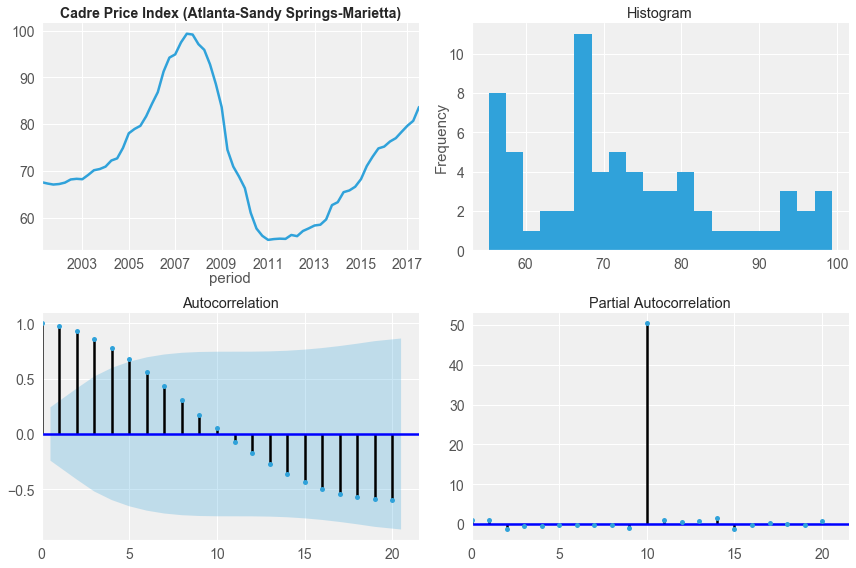

In [891]:
# Time Series Analysis
tsplot(cpi['12060'], title='Cadre Price Index (Atlanta-Sandy Springs-Marietta)', lags=20)

Based on the ACF/PACF plots and the ADF statistics, the market price index is not stationary. 

# 1. Forecasting without Exogenous Variables

## 1.1 ARIMA

In [224]:
# Import packages
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

# Define functions
def ARIMA_forecast(data, h, market, disp=False):
    '''Conduct forecast of given time series (data) over horizon (h) using ARIMA model
    '''
    # split data into training and testing given the horizon of forecast
    X_train = data[:-h]
    X_test = data[-h:]
    # automatically build ARIMA model
    model = pm.auto_arima(X_train, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          start_P=0, 
                          D=0, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    # make a forecast
    forecast, confint = model.predict(n_periods=h, return_conf_int=True)
    forecast = pd.DataFrame({'forecast':forecast, 'lower':confint[:,0], 'upper':confint[:,1]}, index=X_test.index)
    error = mean_absolute_percentage_error(X_test, forecast['forecast'])
    # visualize forecast result
    if disp:
        print(model.summary())
        model.plot_diagnostics(figsize=(10,8))
    
        plt.figure(figsize=(10,6))
        plt.suptitle("ARIMA Forecast of " + market + " over " + str(h) + " Quarters", fontsize=18)
        plt.title("Forecast Error (MAPE) = " + str(round(error,4)), fontsize=16)
        plt.ylabel("Price Index", fontsize=16)
        plt.plot(X_train, label='train')
        plt.plot(X_test, label='test')
        plt.plot(forecast['forecast'], color='darkgreen', label='forecast')
        plt.fill_between(forecast.index, forecast['lower'], forecast['upper'], color='k', alpha=.15)
        plt.legend()
    return forecast, error

Fit ARIMA: order=(1, 2, 1); AIC=223.176, BIC=231.554, Fit time=0.057 seconds
Fit ARIMA: order=(0, 2, 0); AIC=223.690, BIC=227.879, Fit time=0.004 seconds
Fit ARIMA: order=(1, 2, 0); AIC=223.073, BIC=229.356, Fit time=0.021 seconds
Fit ARIMA: order=(0, 2, 1); AIC=221.651, BIC=227.934, Fit time=0.038 seconds
Fit ARIMA: order=(0, 2, 2); AIC=222.851, BIC=231.228, Fit time=0.040 seconds
Fit ARIMA: order=(1, 2, 2); AIC=224.756, BIC=235.228, Fit time=0.074 seconds
Total fit time: 0.246 seconds
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   60
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -107.825
Method:                       css-mle   S.D. of innovations              1.458
Date:                Tue, 17 Mar 2020   AIC                            221.651
Time:                        21:28:47   BIC                            227.934
Sample:                           

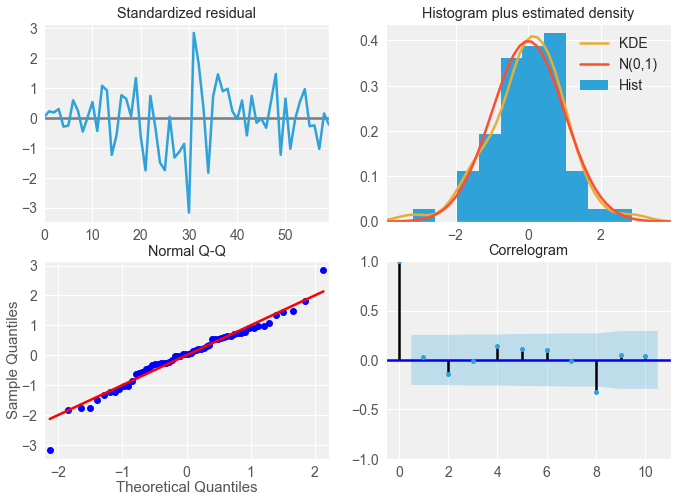

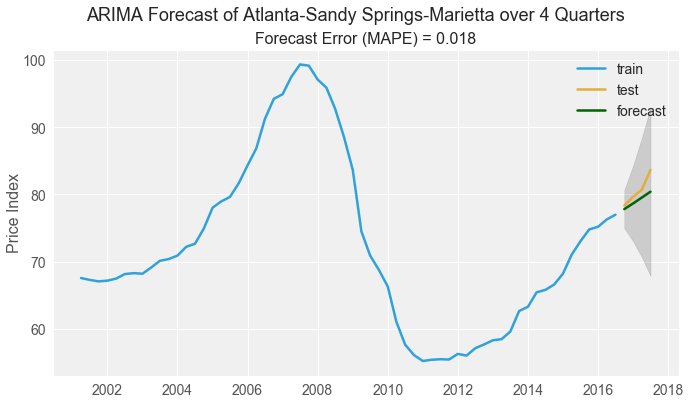

In [226]:
# Eample of market '12060'
forecast, error = ARIMA_forecast(data=cpi['12060'], h=4, market='Atlanta-Sandy Springs-Marietta', disp=True)

In [237]:
# Apply ARIMA forecast on each of the 10 markets
forecast_1_1 = []
error_1_1 = []
for m in cpi.columns.values:
    forecast, error = ARIMA_forecast(data=cpi[m], h=4, market=m, disp=False)
    forecast_1_1.append(forecast['forecast'])
    error_1_1.append(error)
forecast_1_1 = pd.concat(forecast_1_1, axis=1)
forecast_1_1.columns = cpi.columns
forecast_1_1

Fit ARIMA: order=(1, 2, 1); AIC=223.176, BIC=231.554, Fit time=0.055 seconds
Fit ARIMA: order=(0, 2, 0); AIC=223.690, BIC=227.879, Fit time=0.004 seconds
Fit ARIMA: order=(1, 2, 0); AIC=223.073, BIC=229.356, Fit time=0.022 seconds
Fit ARIMA: order=(0, 2, 1); AIC=221.651, BIC=227.934, Fit time=0.032 seconds
Fit ARIMA: order=(0, 2, 2); AIC=222.851, BIC=231.228, Fit time=0.047 seconds
Fit ARIMA: order=(1, 2, 2); AIC=224.756, BIC=235.228, Fit time=0.077 seconds
Total fit time: 0.250 seconds
Fit ARIMA: order=(1, 2, 1); AIC=214.317, BIC=222.694, Fit time=0.061 seconds
Fit ARIMA: order=(0, 2, 0); AIC=210.601, BIC=214.790, Fit time=0.007 seconds
Fit ARIMA: order=(1, 2, 0); AIC=212.403, BIC=218.686, Fit time=0.026 seconds
Fit ARIMA: order=(0, 2, 1); AIC=212.364, BIC=218.647, Fit time=0.016 seconds
Total fit time: 0.116 seconds
Fit ARIMA: order=(1, 2, 1); AIC=200.405, BIC=208.782, Fit time=0.048 seconds
Fit ARIMA: order=(0, 2, 0); AIC=198.430, BIC=202.619, Fit time=0.003 seconds
Fit ARIMA: order

,12060,14460,16980,19100,26420,31080,33100,35620,37980,47900
period,,,,,,,,,,
2016-10-01,77.8252,104.9133,82.8296,98.8646,104.4411,117.5918,107.7262,130.8326,97.2051,98.8206
2017-01-01,78.6717,104.5310,83.2086,98.8376,104.3945,121.1200,111.5298,133.8507,98.4026,96.6177
2017-04-01,79.5357,104.1566,83.5867,98.8118,104.3504,124.6975,115.3605,136.9138,99.6090,94.3676
2017-07-01,80.4170,103.7899,83.9639,98.7860,104.3091,128.3242,119.2599,140.0217,100.8245,92.0705


## 1.2 VECM

In [367]:
# Import packages
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

# Define functions
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,3)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [368]:
h = 4 # horizon of forecast
# Split data into training and testing given the horizon of forecast
X_train, X_test = cpi[:-h], cpi[-h:]
print(X_train.shape, X_test.shape)

(62, 10) (4, 10)


In [369]:
# Co-integration Test
cointegration_test(X_train)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
12060  ::  609.16    > 219.4051  =>   True
14460  ::  468.86    > 179.5199  =>   True
16980  ::  350.36    > 143.6691  =>   True
19100  ::  256.84    > 111.7797  =>   True
26420  ::  194.09    > 83.9383   =>   True
31080  ::  139.28    > 60.0627   =>   True
33100  ::  93.86     > 40.1749   =>   True
35620  ::  54.76     > 24.2761   =>   True
37980  ::  32.27     > 12.3212   =>   True
47900  ::  15.55     > 4.1296    =>   True


In [370]:
# Build a VECM model
model = VECM(endog = X_train, k_ar_diff = 1, coint_rank = 1, deterministic = 'ci')
result = model.fit()
result.summary()

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



,coef,std err,z,P>|z|,[0.025,0.975]
L1.12060,0.1416,0.210,0.673,0.501,-0.271,0.554
L1.14460,0.2046,0.211,0.969,0.332,-0.209,0.618
L1.16980,0.0730,0.228,0.320,0.749,-0.373,0.519
L1.19100,0.0855,0.187,0.458,0.647,-0.280,0.451
L1.26420,-0.1841,0.175,-1.053,0.293,-0.527,0.159
L1.31080,0.2724,0.202,1.350,0.177,-0.123,0.668
L1.33100,0.3403,0.185,1.836,0.066,-0.023,0.704
L1.35620,0.1100,0.160,0.686,0.493,-0.204,0.424
L1.37980,0.0078,0.264,0.030,0.976,-0.509,0.525
L1.47900,-0.1985,0.193,-1.027,0.304,-0.577,0.180


In [371]:
# Make a Forecast
forecast, lower, upper = result.predict(h, 0.05)
forecast_1_2 = pd.DataFrame(forecast, index=X_test.index, columns=X_test.columns)
lower_1_2 = pd.DataFrame(lower, index=X_test.index, columns=X_test.columns)
upper_1_2 = pd.DataFrame(upper, index=X_test.index, columns=X_test.columns)
forecast_1_2

,12060,14460,16980,19100,26420,31080,33100,35620,37980,47900
period,,,,,,,,,,
2016-10-01,79.4288,106.5827,84.3122,100.7679,105.2804,117.3929,107.6932,131.5302,98.0321,99.9897
2017-01-01,82.2087,107.7823,86.4358,102.6984,106.0327,120.6545,111.1069,134.8638,100.1225,99.6275
2017-04-01,84.8721,108.6945,88.4996,104.3274,106.6385,123.7963,114.3176,137.7014,102.2964,99.5275
2017-07-01,87.3558,109.5102,90.4696,105.7626,107.1417,126.7593,117.3382,140.2155,104.5134,99.5784


In [372]:
# Forecast Error
error_1_2 = [mean_absolute_percentage_error(X_test[m], forecast_1_2[m]) for m in cpi.columns.values]

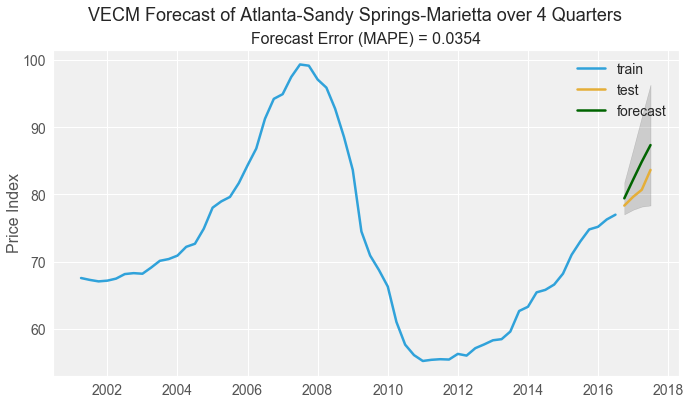

In [373]:
# Example of market '12060'
plt.figure(figsize=(10,6))
plt.suptitle("VECM Forecast of Atlanta-Sandy Springs-Marietta over " + str(h) + " Quarters", fontsize=18)
plt.title("Forecast Error (MAPE) = " + str(round(error_1_2[0],4)), fontsize=16)
plt.ylabel("Price Index", fontsize=16)
plt.plot(X_train['12060'], label='train')
plt.plot(X_test['12060'], label='test')
plt.plot(forecast_1_2['12060'], color='darkgreen', label='forecast')
plt.fill_between(forecast_1_2.index, lower[:,0], upper[:,0], color='k', alpha=.15)
plt.legend()

## 1.3 VAR

In [374]:
# Import packages
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson

# Define functions
def grangers_causation_matrix(data, variables, maxlag=12, test='ssr_chi2test', verbose=False):  
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

def inverse_transform(forecast, X0, X1):
    X_diff = X1 - X0
    X_inverse = forecast.cumsum() + X_diff
    X_inverse = X_inverse.cumsum() + X1
    # X_inverse = X_inverse.apply(np.exp, axis=0)
    return X_inverse

ADF Statistic: -2.588590
p-value: 0.095378
Critical Values:
	1%: -3.537
	5%: -2.908
	10%: -2.591


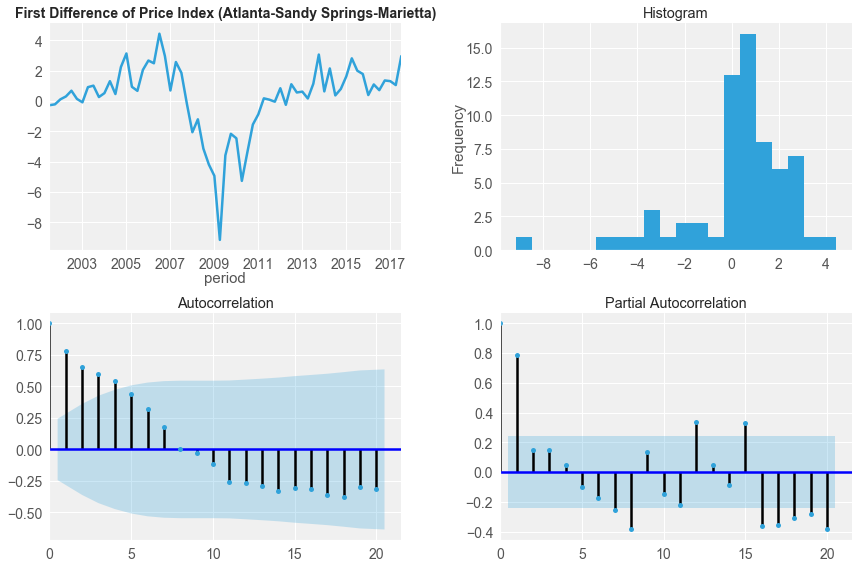

In [375]:
# First difference
df_diff1 = cpi.diff(1).dropna()
tsplot(df_diff1['12060'], title='First Difference of Price Index (Atlanta-Sandy Springs-Marietta)', lags=20)

ADF Statistic: -9.571538
p-value: 0.000000
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592


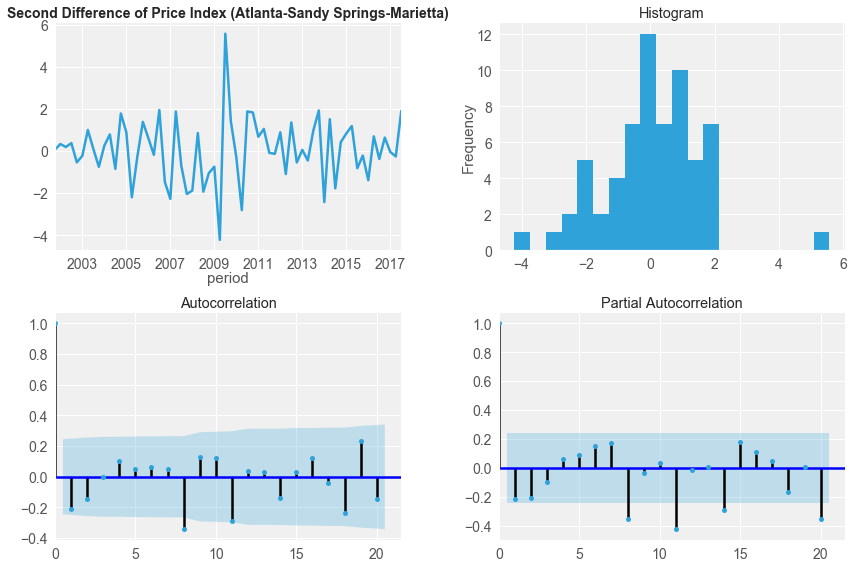

In [376]:
# Second difference
df_diff2 = df_diff1.diff(1).dropna()
tsplot(df_diff2['12060'], title='Second Difference of Price Index (Atlanta-Sandy Springs-Marietta)', lags=20)

After taking the second difference on the series, the market price index becomes stationary.

In [377]:
h = 4 # horizon of forecast
# Split data into training and testing given the horizon of forecast
X_train, X_test = cpi[:-h], cpi[-h:]
print(X_train.shape, X_test.shape)

(62, 10) (4, 10)


In [378]:
# Second difference
X_train_transformed = X_train.diff(1).diff(1).dropna()
X_train_transformed.head()

,12060,14460,16980,19100,26420,31080,33100,35620,37980,47900
period,,,,,,,,,,
2001-10-01,0.0589,1.3486,0.8960,-0.4587,0.1417,-0.7112,0.6607,0.1563,-0.2421,0.1154
2002-01-01,0.3319,-1.0399,-0.9444,-0.6061,0.4105,0.3991,0.0531,-0.2257,-0.5243,-0.4957
2002-04-01,0.1892,-0.2326,-0.6485,-0.0268,-0.0556,-0.4819,1.3239,0.4815,0.7158,-0.8428
2002-07-01,0.3761,0.2975,1.0847,1.7682,-0.1589,0.4538,-1.6056,-0.6879,-0.2632,1.0509
2002-10-01,-0.5390,0.4861,0.3272,-0.9296,0.4817,0.0793,1.1724,1.3807,0.4987,0.0787


In [379]:
# Testing Causation using Granger’s Causality Test
grangers_causation_matrix(data=X_train_transformed, variables=X_train_transformed.columns)

,12060_x,14460_x,16980_x,19100_x,26420_x,31080_x,33100_x,35620_x,37980_x,47900_x
12060_y,1.0000,0.0220,0.0381,0.0185,0.0493,0.0003,0.0000,0.0023,0.0004,0.0945
14460_y,0.0000,1.0000,0.0000,0.0076,0.0000,0.0000,0.0007,0.0000,0.0000,0.0000
16980_y,0.0023,0.0407,1.0000,0.0000,0.3640,0.0031,0.0000,0.0000,0.2190,0.2859
19100_y,0.0045,0.0002,0.0000,1.0000,0.0002,0.0000,0.0000,0.0015,0.0073,0.0006
26420_y,0.0000,0.0968,0.0000,0.0613,1.0000,0.0038,0.0565,0.0011,0.1461,0.0153
31080_y,0.0057,0.0040,0.2948,0.0375,0.0001,1.0000,0.0002,0.0000,0.0002,0.0017
33100_y,0.0834,0.4420,0.1702,0.1522,0.0147,0.0002,1.0000,0.0885,0.0080,0.0244
35620_y,0.0001,0.0003,0.0001,0.0001,0.0656,0.0001,0.0000,1.0000,0.0000,0.0252
37980_y,0.0004,0.0339,0.0227,0.0003,0.0003,0.0044,0.0049,0.4848,1.0000,0.1766
47900_y,0.0000,0.0016,0.0020,0.0020,0.0000,0.0000,0.0000,0.0002,0.0089,1.0000


We can see that, in the equation of '31080_y', we cannot reject null hypothesis that variable '16980_x' doesn't granger-cause any effect on '31080_y' since the p-value 0.2948 is significantly non-zero. Thus, it is necessary to use VAR model to capture the interdependence among those price indexes. 

In [380]:
# Build a VAR model by selecting order (P)
model = VAR(X_train_transformed)
for i in [1,2,3,4]:
    result = model.fit(maxlags=i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  1.9724166263937386
BIC :  5.845791521811182
FPE :  7.512327805144234
HQIC:  3.484425312421445 

Lag Order = 2
AIC :  2.286343213708684
BIC :  9.74656790706641
FPE :  13.877423368790463
HQIC:  5.1922514049984825 

Lag Order = 3
AIC :  1.294457967054882
BIC :  12.405789423698927
FPE :  13.594533306364285
HQIC:  5.612700004886177 

Lag Order = 4
AIC :  -3.660927931241453
BIC :  11.167539804498038
FPE :  1.4373809888734193
HQIC:  2.0880376505359273 



/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



In [381]:
# Train a VAR model based on selected order (P)
result = model.fit(maxlags=4)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 17, Mar, 2020
Time:                     23:31:11
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    11.1675
Nobs:                     56.0000    HQIC:                   2.08804
Log likelihood:          -282.100    FPE:                    1.43738
AIC:                     -3.66093    Det(Omega_mle):      0.00591201
--------------------------------------------------------------------
Results for equation 12060
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.050214         0.237935           -0.211           0.833
L1.12060        -0.566054         0.329069           -1.720           0.085
L1.14460        -0.078349         0.635568           -0.123           0.902
L1.1

In [382]:
# Check for serial correlation of residuals using Durbin-Watson statistic
out = durbin_watson(result.resid)
for col, val in zip(X_train.columns, out):
    print(adjust(col), ':', round(val, 2))

12060  : 1.93
14460  : 1.99
16980  : 1.8
19100  : 1.43
26420  : 1.93
31080  : 1.81
33100  : 1.63
35620  : 2.14
37980  : 1.29
47900  : 1.65


In [383]:
# Make a forecast
forecast, lower, upper = result.forecast_interval(X_train_transformed.values[-h:], h, alpha=0.05)
forecast = pd.DataFrame(forecast, index=X_test.index, columns=X_test.columns)
lower = pd.DataFrame(lower, index=X_test.index, columns=X_test.columns)
upper = pd.DataFrame(upper, index=X_test.index, columns=X_test.columns)

# Inverse transform forecast values to the original level
forecast_1_3 = inverse_transform(forecast=forecast, X0=X_train.values[-2], X1=X_train.values[-1])
lower_1_3 = inverse_transform(forecast=lower, X0=X_train.values[-2], X1=X_train.values[-1])
upper_1_3 = inverse_transform(forecast=upper, X0=X_train.values[-2], X1=X_train.values[-1])
forecast_1_3

,12060,14460,16980,19100,26420,31080,33100,35620,37980,47900
period,,,,,,,,,,
2016-10-01,80.3691,107.7633,80.8224,100.1281,105.3179,116.2654,105.0357,129.3907,97.7111,97.7558
2017-01-01,82.2676,109.5236,81.3936,100.3533,103.3055,117.6243,108.7364,132.2921,99.5705,94.9966
2017-04-01,86.6816,112.2567,80.9623,101.3179,103.9256,119.2349,109.0211,136.6645,99.2082,90.7420
2017-07-01,88.6114,113.3906,81.0415,101.0465,104.5778,120.9568,111.7648,140.4292,101.4307,88.7889


In [384]:
# Forecast error
error_1_3 = [mean_absolute_percentage_error(X_test[m], forecast_1_3[m]) for m in cpi.columns.values]

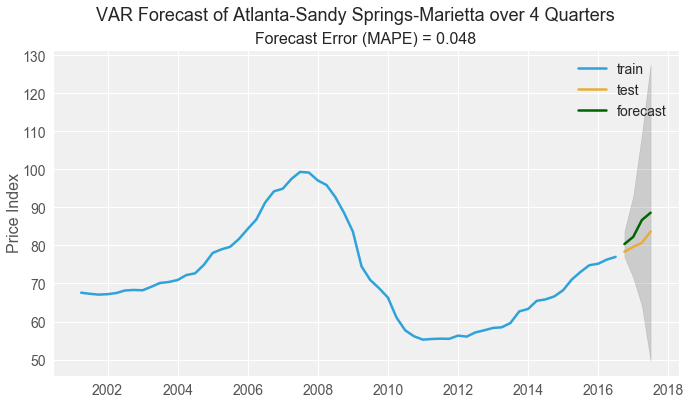

In [386]:
# Example of market '12060'
plt.figure(figsize=(10,6))
plt.suptitle("VAR Forecast of Atlanta-Sandy Springs-Marietta over " + str(h) + " Quarters", fontsize=18)
plt.title("Forecast Error (MAPE) = " + str(round(error_1_3[0],4)), fontsize=16)
plt.ylabel("Price Index", fontsize=16)
plt.plot(X_train['12060'], label='train')
plt.plot(X_test['12060'], label='test')
plt.plot(forecast_1_3['12060'], color='darkgreen', label='forecast')
plt.fill_between(forecast_1_3.index, lower_1_3['12060'], upper_1_3['12060'], color='k', alpha=.15)
plt.legend()

## 1.4 LSTM

In [839]:
# Import packages
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
# from keras.losses import mean_absolute_percentage_error

# Define functions
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def LSTM_forecast(data, timesteps, h, market, disp=False):
    '''data can be either one time series or multiple time series with the last column being the series to forecast
    '''
    if type(data) is pd.Series:
        data = data.to_frame()
    
    features = data.shape[1]
    reframed = series_to_supervised(data, timesteps, 1)
    selected = [i for i in range(timesteps*features)] + [reframed.shape[1]-1]
    reframed = reframed.iloc[:, selected]
    
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(reframed)
    X, y = scaled[:, :-1], scaled[:, -1]
    
    # split into train and test datasets
    X_train, y_train = X[0:-h, :], y[0:-h]
    X_test, y_test = X[-h:, :], y[-h:]
    print('Dimensions:')
    print('--X_train: ', X_train.shape)
    print('--y_train: ', y_train.shape)
    print('--X_test:  ', X_test.shape)
    print('--y_test:  ', y_test.shape)
    
    # reshape input to be 3D [samples, timesteps, features]
    X_train_reshape = X_train.reshape(X_train.shape[0], timesteps, features)
    X_test_reshape = X_test.reshape(X_test.shape[0], timesteps, features)
    print('Dimensions after reshaping:')
    print('--X_train_reshape: ', X_train_reshape.shape)
    print('--X_test_reshape:  ', X_test_reshape.shape)
    
    # design the network architecture
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshape.shape[1], X_train_reshape.shape[2])))
    #model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    #model.add(Dense(25))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    result = model.fit(X_train_reshape, y_train, epochs=100, batch_size=40, 
                       validation_data=(X_test_reshape, y_test), 
                       callbacks=[EarlyStopping(monitor='val_loss',mode='min')], verbose=2, shuffle=False)
    # make a forecast
    y_predict = model.predict(X_test_reshape)
    # invert scaling for forecast
    y_predict_inverse = np.concatenate((X_test, y_predict), axis=1)
    y_predict_inverse = scaler.inverse_transform(y_predict_inverse)
    forecast = pd.DataFrame({'forecast':y_predict_inverse[:,-1]}, index=data[-h:].index)
    error = mean_absolute_percentage_error(reframed.iloc[-h:,-1], forecast['forecast'])
    
    # visualize forecast
    if disp:
        plt.figure(figsize=(10,6))
        plt.plot(result.history['loss'], label='train')
        plt.plot(result.history['val_loss'], label='test')
        plt.ylabel("Loss", fontsize=16)
        plt.legend()
    
        plt.figure(figsize=(10,6))
        plt.suptitle("LSTM Forecast of " + market + " over " + str(h) + " Quarters", fontsize=18)
        plt.title("with " + str(timesteps) + " Quarters Lookback  Forecast Error (MAPE) = " + str(round(error,4)), fontsize=16)
        plt.ylabel("Price Index", fontsize=16)
        plt.plot(reframed.iloc[:-h,-1], label='train')
        plt.plot(reframed.iloc[-h:,-1], label='test')
        plt.plot(forecast['forecast'], color='darkgreen', label='forecast')
        # plt.fill_between(forecast.index, forecast['lower'], forecast['upper'], color='k', alpha=.15)
        plt.legend()
    
    return forecast, error


### 1.4.1. LTSM Forecasting with Single Features

Dimensions:
--X_train:  (58, 4)
--y_train:  (58,)
--X_test:   (4, 4)
--y_test:   (4,)
Dimensions after reshaping:
--X_train_reshape:  (58, 4, 1)
--X_test_reshape:   (4, 4, 1)
Train on 58 samples, validate on 4 samples
Epoch 1/100
 - 2s - loss: 0.3871 - val_loss: 0.5306
Epoch 2/100
 - 0s - loss: 0.3566 - val_loss: 0.4902
Epoch 3/100
 - 0s - loss: 0.3239 - val_loss: 0.4475
Epoch 4/100
 - 0s - loss: 0.2942 - val_loss: 0.4014
Epoch 5/100
 - 0s - loss: 0.2656 - val_loss: 0.3506
Epoch 6/100
 - 0s - loss: 0.2329 - val_loss: 0.2933
Epoch 7/100
 - 0s - loss: 0.2061 - val_loss: 0.2282
Epoch 8/100
 - 0s - loss: 0.1677 - val_loss: 0.1545
Epoch 9/100
 - 0s - loss: 0.1575 - val_loss: 0.0802
Epoch 10/100
 - 0s - loss: 0.1409 - val_loss: 0.0262
Epoch 11/100
 - 0s - loss: 0.1580 - val_loss: 0.0211
Epoch 12/100
 - 0s - loss: 0.1493 - val_loss: 0.0213


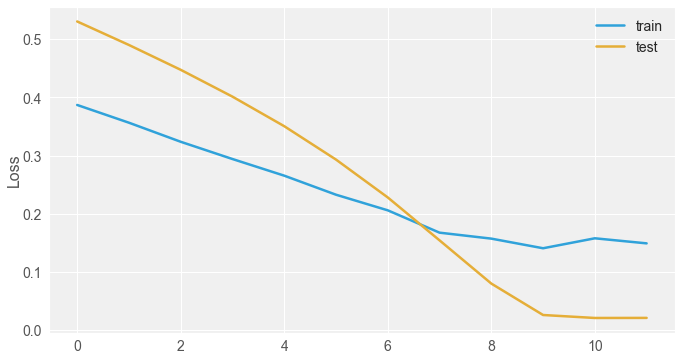

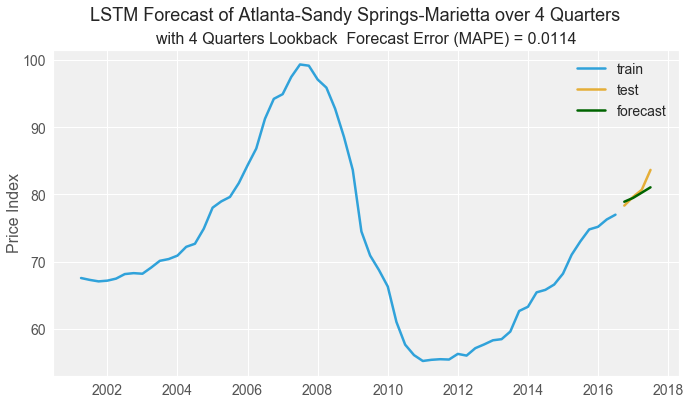

In [530]:
# Eample of market '12060' with 4 quarters lookback
forecast, error = LSTM_forecast(cpi['12060'], timesteps=4, h=4, market='Atlanta-Sandy Springs-Marietta', disp=True)

In [531]:
# Apply LTSM forecast on each of the 10 markets without considering other market information
forecast_1_4_1 = []
error_1_4_1 = []
for m in cpi.columns.values:
    forecast, error = LSTM_forecast(cpi[m], timesteps=4, h=4, market=m, disp=False)
    forecast_1_4_1.append(forecast['forecast'])
    error_1_4_1.append(error)
forecast_1_4_1 = pd.concat(forecast_1_4_1, axis=1)
forecast_1_4_1.columns = cpi.columns
forecast_1_4_1

Dimensions:
--X_train:  (58, 4)
--y_train:  (58,)
--X_test:   (4, 4)
--y_test:   (4,)
Dimensions after reshaping:
--X_train_reshape:  (58, 4, 1)
--X_test_reshape:   (4, 4, 1)
Train on 58 samples, validate on 4 samples
Epoch 1/100
 - 3s - loss: 0.4077 - val_loss: 0.5564
Epoch 2/100
 - 0s - loss: 0.3753 - val_loss: 0.5185
Epoch 3/100
 - 0s - loss: 0.3481 - val_loss: 0.4792
Epoch 4/100
 - 0s - loss: 0.3206 - val_loss: 0.4376
Epoch 5/100
 - 0s - loss: 0.2934 - val_loss: 0.3929
Epoch 6/100
 - 0s - loss: 0.2633 - val_loss: 0.3440
Epoch 7/100
 - 0s - loss: 0.2319 - val_loss: 0.2893
Epoch 8/100
 - 0s - loss: 0.1987 - val_loss: 0.2277
Epoch 9/100
 - 0s - loss: 0.1790 - val_loss: 0.1625
Epoch 10/100
 - 0s - loss: 0.1536 - val_loss: 0.0982
Epoch 11/100
 - 0s - loss: 0.1482 - val_loss: 0.0480
Epoch 12/100
 - 0s - loss: 0.1504 - val_loss: 0.0252
Epoch 13/100
 - 0s - loss: 0.1583 - val_loss: 0.0274
Dimensions:
--X_train:  (58, 4)
--y_train:  (58,)
--X_test:   (4, 4)
--y_test:   (4,)
Dimensions after

Train on 58 samples, validate on 4 samples
Epoch 1/100
 - 4s - loss: 0.5261 - val_loss: 0.7665
Epoch 2/100
 - 0s - loss: 0.4840 - val_loss: 0.7049
Epoch 3/100
 - 0s - loss: 0.4424 - val_loss: 0.6386
Epoch 4/100
 - 0s - loss: 0.3968 - val_loss: 0.5653
Epoch 5/100
 - 0s - loss: 0.3523 - val_loss: 0.4822
Epoch 6/100
 - 0s - loss: 0.2969 - val_loss: 0.3859
Epoch 7/100
 - 0s - loss: 0.2377 - val_loss: 0.2739
Epoch 8/100
 - 0s - loss: 0.1917 - val_loss: 0.1443
Epoch 9/100
 - 0s - loss: 0.1384 - val_loss: 0.0185
Epoch 10/100
 - 0s - loss: 0.1329 - val_loss: 0.1250


,12060,14460,16980,19100,26420,31080,33100,35620,37980,47900
period,,,,,,,,,,
2016-10-01,78.5323,106.3214,84.0503,101.1244,109.3471,112.1411,99.9915,126.7390,95.8238,107.0792
2017-01-01,79.0623,106.8507,84.4212,101.4523,109.4011,114.2271,101.9651,128.5015,96.9107,106.2111
2017-04-01,79.7833,107.8624,85.0749,101.9649,109.3789,116.7633,103.9583,129.9821,97.8187,104.9386
2017-07-01,80.5174,110.0069,85.9389,102.9779,109.3083,119.2521,105.5118,131.6523,98.7243,104.2062


### 1.4.2 LTSM Forecasting with Multiple Features

             14460   16980   19100   26420   31080   33100   35620   37980  \
period                                                                       
2001-04-01 76.3939 66.3016 70.1133 69.9588 60.9522 60.8050 63.1284 70.9650   
2001-07-01 75.5278 66.7364 70.1580 69.7023 61.4280 60.8078 63.3655 71.6024   
2001-10-01 76.0102 68.0672 69.7440 69.5874 61.1926 61.4712 63.7589 71.9976   
2002-01-01 75.4528 68.4536 68.7239 69.8830 61.3562 62.1877 63.9266 71.8686   
2002-04-01 74.6628 68.1914 67.6770 70.1230 61.0380 64.2281 64.5758 72.4553   

             47900   12060  
period                      
2001-04-01 62.4131 67.5723  
2001-07-01 63.1300 67.2926  
2001-10-01 63.9622 67.0719  
2002-01-01 64.2988 67.1831  
2002-04-01 63.7926 67.4835  
Dimensions:
--X_train:  (61, 10)
--y_train:  (61,)
--X_test:   (4, 10)
--y_test:   (4,)
Dimensions after reshaping:
--X_train_reshape:  (61, 1, 10)
--X_test_reshape:   (4, 1, 10)
Train on 61 samples, validate on 4 samples
Epoch 1/100
 - 5s - loss: 0.

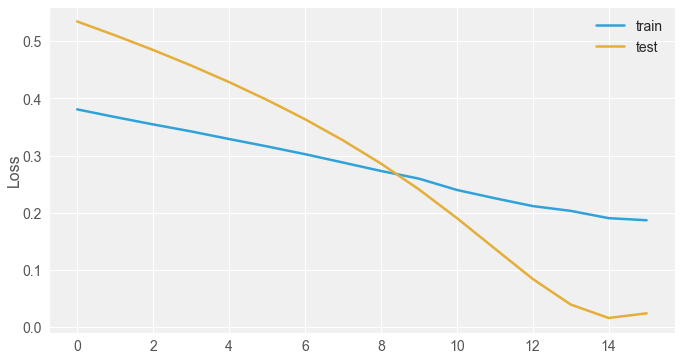

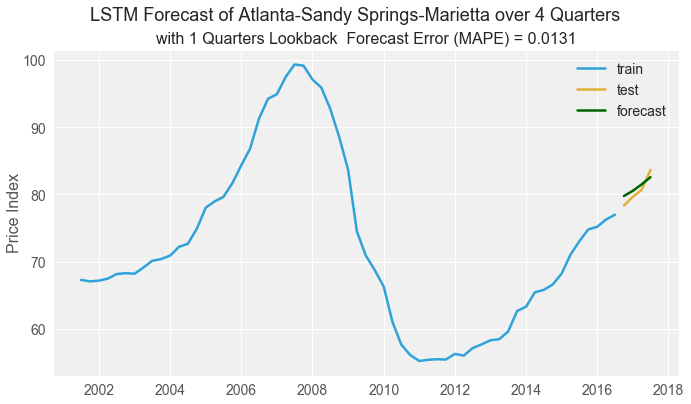

In [577]:
# Eample of market '12060' with 1 quarter lookback and other market information
reorder = [m for m in cpi.columns.values if m != '12060'] + ['12060']
forecast, error = LSTM_forecast(cpi[reorder], timesteps=1, h=4, market='Atlanta-Sandy Springs-Marietta', disp=True)

In [578]:
# Apply LTSM forecast on each of the 10 markets by considering other market information
forecast_1_4_2 = []
error_1_4_2 = []
for m in cpi.columns.values:
    reorder = [k for k in cpi.columns.values if k != m] + [m] # ensure the last column is the series to forecast
    forecast, error = LSTM_forecast(cpi[reorder], timesteps=1, h=4, market=m, disp=False)
    forecast_1_4_2.append(forecast['forecast'])
    error_1_4_2.append(error)
forecast_1_4_2 = pd.concat(forecast_1_4_2, axis=1)
forecast_1_4_2.columns = cpi.columns
forecast_1_4_2

Dimensions:
--X_train:  (61, 10)
--y_train:  (61,)
--X_test:   (4, 10)
--y_test:   (4,)
Dimensions after reshaping:
--X_train_reshape:  (61, 1, 10)
--X_test_reshape:   (4, 1, 10)
Train on 61 samples, validate on 4 samples
Epoch 1/100
 - 5s - loss: 0.4021 - val_loss: 0.5821
Epoch 2/100
 - 0s - loss: 0.3852 - val_loss: 0.5553
Epoch 3/100
 - 0s - loss: 0.3703 - val_loss: 0.5285
Epoch 4/100
 - 0s - loss: 0.3581 - val_loss: 0.5010
Epoch 5/100
 - 0s - loss: 0.3428 - val_loss: 0.4724
Epoch 6/100
 - 0s - loss: 0.3281 - val_loss: 0.4422
Epoch 7/100
 - 0s - loss: 0.3152 - val_loss: 0.4101
Epoch 8/100
 - 0s - loss: 0.2999 - val_loss: 0.3753
Epoch 9/100
 - 0s - loss: 0.2885 - val_loss: 0.3378
Epoch 10/100
 - 0s - loss: 0.2711 - val_loss: 0.2968
Epoch 11/100
 - 0s - loss: 0.2533 - val_loss: 0.2516
Epoch 12/100
 - 0s - loss: 0.2374 - val_loss: 0.2016
Epoch 13/100
 - 0s - loss: 0.2200 - val_loss: 0.1468
Epoch 14/100
 - 0s - loss: 0.2058 - val_loss: 0.0893
Epoch 15/100
 - 0s - loss: 0.1916 - val_loss:

Epoch 8/100
 - 0s - loss: 0.3197 - val_loss: 0.7675
Epoch 9/100
 - 0s - loss: 0.2991 - val_loss: 0.7293
Epoch 10/100
 - 0s - loss: 0.2794 - val_loss: 0.6863
Epoch 11/100
 - 0s - loss: 0.2574 - val_loss: 0.6380
Epoch 12/100
 - 0s - loss: 0.2258 - val_loss: 0.5833
Epoch 13/100
 - 0s - loss: 0.2014 - val_loss: 0.5217
Epoch 14/100
 - 0s - loss: 0.1686 - val_loss: 0.4527
Epoch 15/100
 - 0s - loss: 0.1425 - val_loss: 0.3752
Epoch 16/100
 - 0s - loss: 0.1146 - val_loss: 0.2909
Epoch 17/100
 - 0s - loss: 0.1045 - val_loss: 0.2012
Epoch 18/100
 - 0s - loss: 0.0881 - val_loss: 0.1134
Epoch 19/100
 - 0s - loss: 0.0954 - val_loss: 0.0505
Epoch 20/100
 - 0s - loss: 0.1025 - val_loss: 0.0362
Epoch 21/100
 - 0s - loss: 0.1045 - val_loss: 0.0407
Dimensions:
--X_train:  (61, 10)
--y_train:  (61,)
--X_test:   (4, 10)
--y_test:   (4,)
Dimensions after reshaping:
--X_train_reshape:  (61, 1, 10)
--X_test_reshape:   (4, 1, 10)
Train on 61 samples, validate on 4 samples
Epoch 1/100
 - 7s - loss: 0.3475 - val

,12060,14460,16980,19100,26420,31080,33100,35620,37980,47900
period,,,,,,,,,,
2016-10-01,80.8963,104.5548,85.6123,96.1230,105.6070,111.5542,101.9859,120.0918,99.2271,102.3270
2017-01-01,81.6751,105.4059,86.3298,97.1784,106.7152,113.1075,103.2279,121.6372,100.1174,103.4434
2017-04-01,82.7177,106.4585,87.1687,98.3734,108.1277,115.0542,104.6579,123.3324,101.2414,104.6908
2017-07-01,83.8203,107.6356,88.1026,99.8642,109.7525,117.2801,106.2209,125.3371,102.4326,106.1565


# 2. Forecasting with Exogenous Variables

In [587]:
# Compare Cadre Price Index with exogenous variables
fig = make_subplots(rows=3, cols=1,
                    specs=[[{"secondary_y": True}],[{"secondary_y": True}],[{"secondary_y": True}]])
# Top
fig.add_trace(
    go.Scatter(x=cpi.index, y=cpi['12060'], name="cpi"),
    row=1, col=1, secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=frm.index, y=frm['mortgage30us'], name="frm"),
    row=1, col=1, secondary_y=True,
)

# Middle
fig.add_trace(
    go.Scatter(x=cpi.index, y=cpi['12060'], name="cpi"),
    row=2, col=1, secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=fmhpi.index, y=fmhpi['12060'], name="fmhpi"),
    row=2, col=1, secondary_y=True,
)

# Bottom
fig.add_trace(
    go.Scatter(x=cpi.index, y=cpi['12060'], name="cpi"),
    row=3, col=1, secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=hvi.index, y=hvi['12060'], name="hvi"),
    row=3, col=1, secondary_y=True,
)

fig.update_layout(title='Atlanta-Sandy Springs-Marietta')

In [595]:
# Combine dataframes
df = pd.DataFrame({'cpi':cpi['12060'],'hpi':fmhpi['12060'],'hvi':hvi['12060'],'frm':frm['mortgage30us']})
df.head()

,cpi,hpi,hvi,frm
period,,,,
2001-04-01,67.5723,102.2878,147500.0000,6.9100
2001-07-01,67.2926,104.0061,149400.0000,7.1100
2001-10-01,67.0719,104.6247,151000.0000,6.7200
2002-01-01,67.1831,105.5466,153000.0000,7.1600
2002-04-01,67.4835,106.7660,155300.0000,7.1800


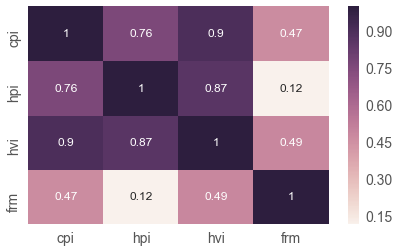

In [596]:
# Correlations among those time series
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, annot_kws={'size':12})
heat_map = plt.gcf()

## 2.1 VECM

In [619]:
# Define functions
def VECM_forecast(data, h, market, disp=False):
    # split data into training and testing given the horizon of forecast
    X_train, X_test = df[:-h], df[-h:]
    
    # build a VECM model
    model = VECM(X_train, k_ar_diff = 3, coint_rank = 4)
    result = model.fit()
    
    # make a Forecast
    forecast, lower, upper = result.predict(h, 0.05)
    forecast = pd.DataFrame(forecast, index=X_test.index, columns=X_test.columns)
    lower = pd.DataFrame(lower, index=X_test.index, columns=X_test.columns)
    upper = pd.DataFrame(upper, index=X_test.index, columns=X_test.columns)
    # forecast Error
    error = mean_absolute_percentage_error(X_test['cpi'], forecast['cpi'])
    
    # visualize forecast result
    if disp:
        print(result.summary())
        
        plt.figure(figsize=(10,6))
        plt.suptitle("VECM Forecast of " + market + " over " + str(h) + " Quarters", fontsize=18)
        plt.title("with Exogenous Variables  Forecast Error (MAPE) = " + str(round(error,4)), fontsize=16)
        plt.ylabel("Price Index", fontsize=16)
        plt.plot(X_train['cpi'], label='train')
        plt.plot(X_test['cpi'], label='test')
        plt.plot(forecast['cpi'], color='darkgreen', label='forecast')
        plt.fill_between(forecast.index, lower['cpi'], upper['cpi'], color='k', alpha=.15)
        plt.legend()
    
    return forecast, error

In [621]:
# Cointegration test
cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
cpi    ::  60.03     > 40.1749   =>   True
hpi    ::  30.3      > 24.2761   =>   True
hvi    ::  14.36     > 12.3212   =>   True
frm    ::  4.18      > 4.1296    =>   True


/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



Det. terms outside the coint. relation & lagged endog. parameters for equation cpi
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.cpi         0.3697      0.133      2.778      0.005       0.109       0.630
L1.hpi         0.4040      0.173      2.337      0.019       0.065       0.743
L1.hvi        -0.0004      0.000     -1.671      0.095      -0.001    6.54e-05
L1.frm         0.7755      0.465      1.669      0.095      -0.135       1.686
L2.cpi         0.1944      0.132      1.475      0.140      -0.064       0.453
L2.hpi         0.1847      0.101      1.831      0.067      -0.013       0.382
L2.hvi        -0.0002      0.000     -0.809      0.419      -0.001       0.000
L2.frm        -0.0377      0.448     -0.084      0.933      -0.915       0.840
L3.cpi         0.1758      0.122      1.436      0.151      -0.064       0.416
L3.hpi         0.1564      0.160      0.975     

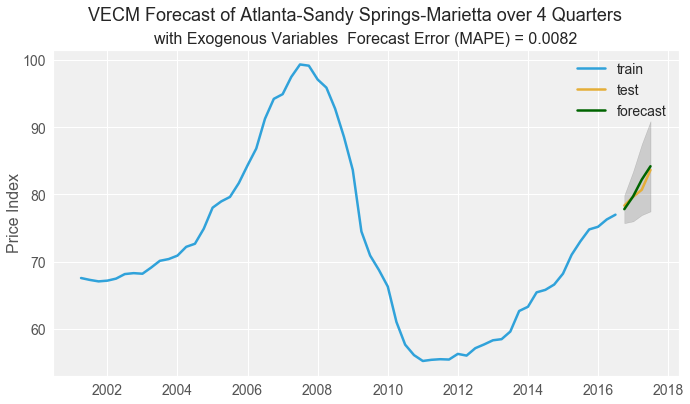

In [620]:
# Example of market '12060'
forecast, error = VECM_forecast(df, h, market='Atlanta-Sandy Springs-Marietta', disp=True)

In [622]:
# Apply VECM forecast on each of the 10 markets
forecast_2_1 = []
error_2_1 = []
for m in cpi.columns.values:
    df = pd.DataFrame({'cpi':cpi[m],'hpi':fmhpi[m],'hvi':hvi[m],'frm':frm['mortgage30us']})
    forecast, error = VECM_forecast(data=df, h=4, market=m, disp=False)
    forecast_2_1.append(forecast['cpi'])
    error_2_1.append(error)
forecast_2_1 = pd.concat(forecast_2_1, axis=1)
forecast_2_1.columns = cpi.columns
forecast_2_1

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/yunkunxu/miniconda3/lib/python3.6

,12060,14460,16980,19100,26420,31080,33100,35620,37980,47900
period,,,,,,,,,,
2016-10-01,77.8157,105.3712,82.5287,99.7440,106.2984,116.8707,106.7961,131.2485,96.4983,99.7404
2017-01-01,79.7288,106.1739,82.9386,101.7726,108.8860,119.4222,109.1703,133.8396,96.8838,99.5020
2017-04-01,82.2132,106.9854,83.6453,104.4865,111.7878,122.2040,111.6489,136.2521,97.0789,100.1474
2017-07-01,84.2034,108.2170,84.4414,107.6459,115.5374,125.1293,114.3648,139.4057,96.9141,102.0177


## 2.2 VAR

In [635]:
# Remove seasonality
fmhpi_sa = fmhpi.diff(4).dropna()
fmhpi_sa.head()

,12060,14460,16980,19100,26420,31080,33100,35620,37980,47900
period,,,,,,,,,,
2002-04-01,4.4782,11.6178,7.7056,3.8563,4.5428,14.2905,15.1867,14.6061,10.1617,14.6847
2002-07-01,4.4347,13.1130,8.4038,4.0053,4.8423,17.8914,16.4073,16.4997,12.0276,16.7103
2002-10-01,4.2819,14.3905,8.7817,3.7489,5.0661,20.4174,17.3854,17.9314,13.5823,18.0777
2003-01-01,3.0789,14.5201,9.2857,3.5525,5.1706,22.0341,19.0751,18.9176,14.3700,17.8175
2003-04-01,3.5333,12.3409,9.2379,2.7209,4.4450,22.7934,18.9631,17.7113,14.7221,18.0847


In [636]:
fmhpi_sa.iplot(kind='scatter',title='Freddie Mac Housing Price Index (Seasonality Adjusted)')

ADF Statistic: -2.583356
p-value: 0.096486
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595


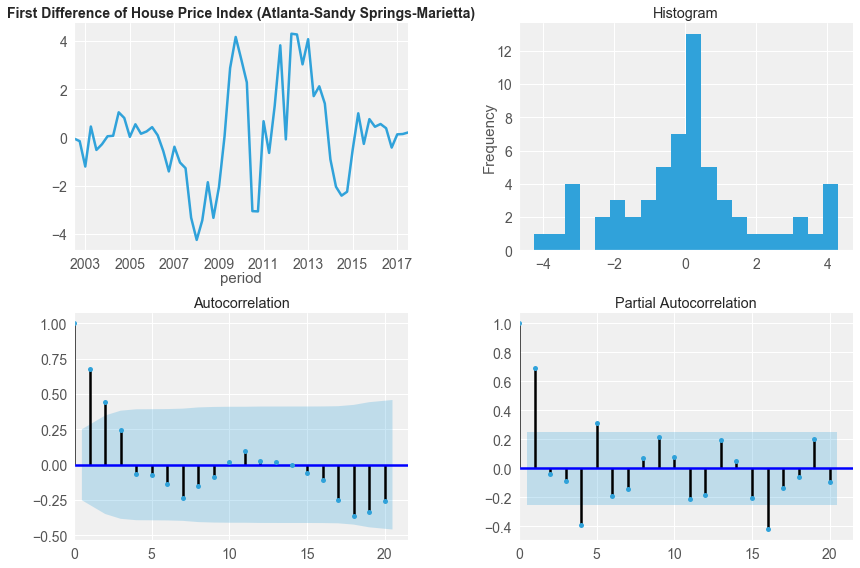

In [640]:
# First difference of seaonality-adjusted House Price Index
fmhpi_diff1 = fmhpi_sa.diff(1).dropna()
tsplot(fmhpi_diff1['12060'], title='First Difference of House Price Index (Atlanta-Sandy Springs-Marietta)', lags=20)

ADF Statistic: -5.512006
p-value: 0.000002
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595


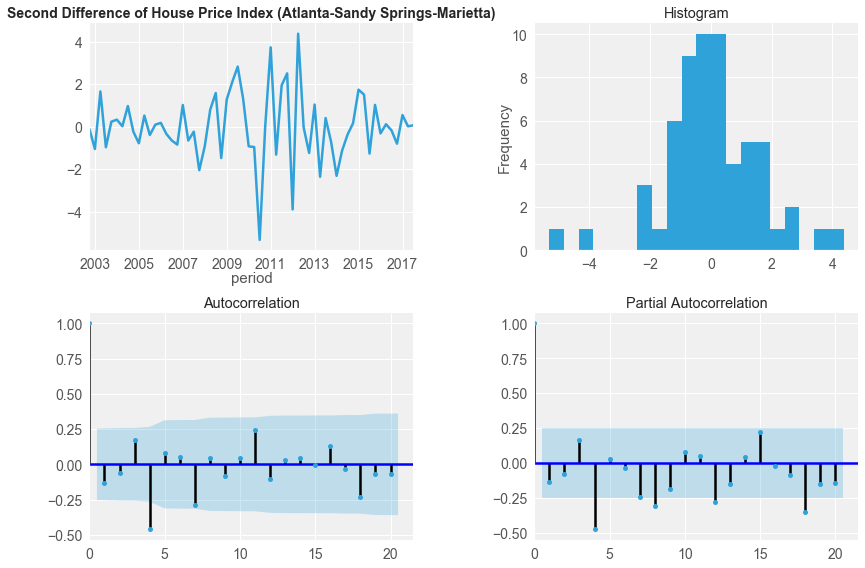

In [655]:
# Second difference of seaonality-adjusted House Price Index
fmhpi_diff2 = fmhpi_diff1.diff(1).dropna()
tsplot(fmhpi_diff2['12060'], title='Second Difference of House Price Index (Atlanta-Sandy Springs-Marietta)', lags=20)

ADF Statistic: -2.157571
p-value: 0.222004
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593


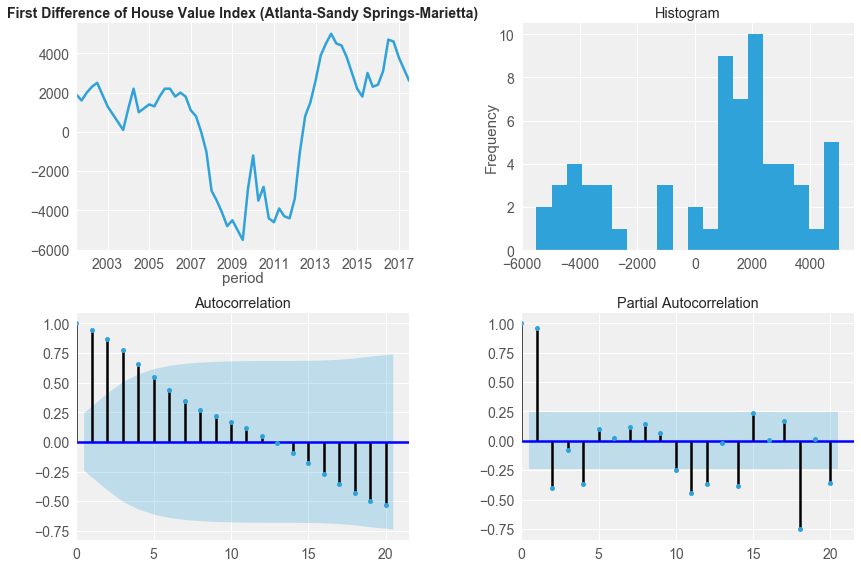

In [679]:
# First difference of House Value Index
hvi_diff1 = hvi.diff(1).dropna()
tsplot(hvi_diff1['12060'], title='First Difference of House Value Index (Atlanta-Sandy Springs-Marietta)', lags=20)

ADF Statistic: -5.927661
p-value: 0.000000
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592


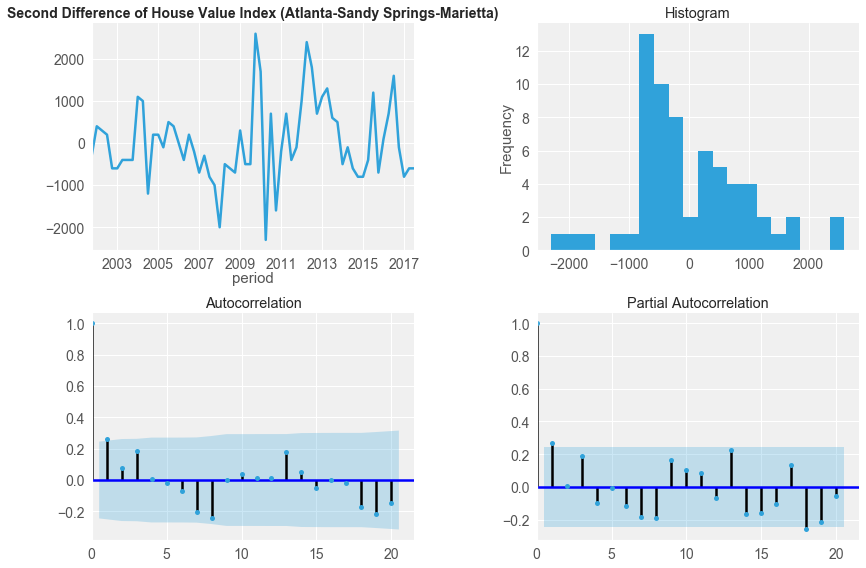

In [684]:
# Second difference of House Value Index
hvi_diff2 = hvi_diff1.diff(1).dropna()
tsplot(hvi_diff2['12060'], title='Second Difference of House Value Index (Atlanta-Sandy Springs-Marietta)', lags=20)

ADF Statistic: -7.669982
p-value: 0.000000
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592


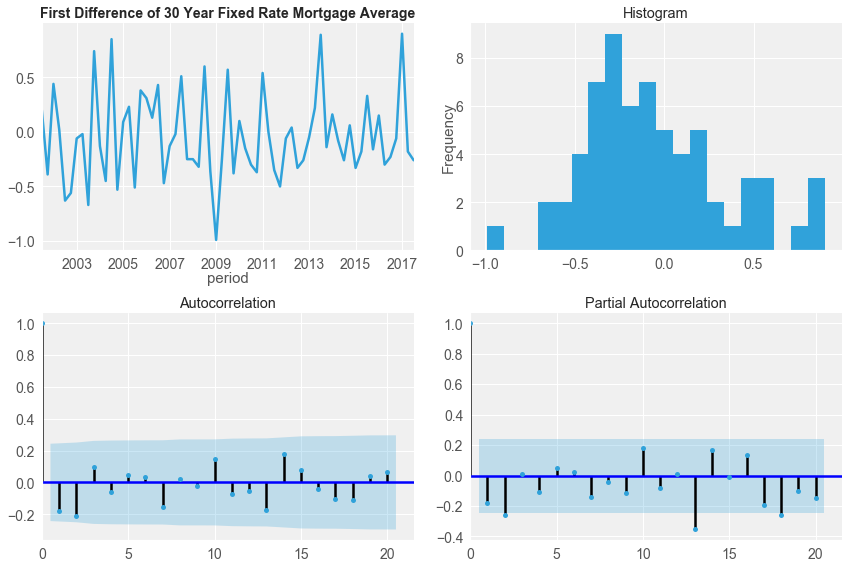

In [644]:
# First difference of mortgage rates
frm_diff1 = frm.diff(1).dropna()
tsplot(frm_diff1['mortgage30us'], title='First Difference of 30 Year Fixed Rate Mortgage Average', lags=20)

In [824]:
# Define functions
def VAR_forecast(data, maxlags, h, market, disp=False):
    
    # Combine transformed dataframes
    dt_transformed = data.copy()
    dt_transformed['cpi'] = data['cpi'].diff(1).diff(1)
    dt_transformed['hpi'] = data['hpi'].diff(4).diff(1).diff(1)
    dt_transformed['hvi'] = data['hvi'].diff(1).diff(1)
    dt_transformed['frm'] = data['frm'].diff(1)
    dt_transformed = dt_transformed.dropna()
    
    # Split data into training and testing given the horizon of forecast
    X_train, X_test = dt_transformed[:-h], dt_transformed[-h:]
    
    # Build a VAR model by selecting order (P)
    model = VAR(X_train)
    # for i in [1,2,3,4,5,10,15,20]:
        # result = model.fit(maxlags=i)
        # print('Lag Order =', i)
        # print('AIC : ', result.aic)
        # print('BIC : ', result.bic)
        # print('FPE : ', result.fpe)
        # print('HQIC: ', result.hqic, '\n')
    
    # Train a VAR model based on selected order (P)
    result = model.fit(maxlags=maxlags)
    
    # Make a forecast
    forecast, lower, upper = result.forecast_interval(X_train.values[-h:], h, alpha=0.05)
    forecast = pd.DataFrame(forecast, index=X_test.index, columns=X_test.columns)
    lower = pd.DataFrame(lower, index=X_test.index, columns=X_test.columns)
    upper = pd.DataFrame(upper, index=X_test.index, columns=X_test.columns)

    # Inverse transform forecast values to the original level
    forecast = inverse_transform(forecast=forecast['cpi'], X0=data['cpi'][-(h+2)], X1=data['cpi'][-(h+1)])
    lower = inverse_transform(forecast=lower['cpi'], X0=data['cpi'][-(h+2)], X1=data['cpi'][-(h+1)])
    upper = inverse_transform(forecast=upper['cpi'], X0=data['cpi'][-(h+2)], X1=data['cpi'][-(h+1)])
    
    # Forecast error
    error = mean_absolute_percentage_error(data['cpi'][-h:], forecast)
    
    if disp:
        # Testing Causation using Granger’s Causality Test
        print("**********************************")
        print(grangers_causation_matrix(data=X_train, variables=X_train.columns))
        print("**********************************")
        
        print(result.summary())
        
        # Check for serial correlation of residuals using Durbin-Watson statistic
        out = durbin_watson(result.resid)
        for col, val in zip(X_train.columns, out):
            print(adjust(col), ':', round(val, 2))
        
        plt.figure(figsize=(10,6))
        plt.suptitle("VAR Forecast of " + market + " over " + str(h) + " Quarters", fontsize=18)
        plt.title("with Exogenous Variables  Forecast Error (MAPE) = " + str(round(error,4)), fontsize=16)
        plt.ylabel("Price Index", fontsize=16)
        plt.plot(data['cpi'][:-h], label='train')
        plt.plot(data['cpi'][-h:], label='test')
        plt.plot(forecast, color='darkgreen', label='forecast')
        plt.fill_between(forecast.index, lower, upper, color='k', alpha=.15)
        plt.legend()
        
    return forecast, error

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



**********************************
       cpi_x  hpi_x  hvi_x  frm_x
cpi_y 1.0000 0.0009 0.1549 0.0001
hpi_y 0.0007 1.0000 0.0000 0.0000
hvi_y 0.0003 0.0000 1.0000 0.0031
frm_y 0.0232 0.0099 0.0000 1.0000
**********************************
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 19, Mar, 2020
Time:                     22:02:58
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    15.6142
Nobs:                     53.0000    HQIC:                   14.4244
Log likelihood:          -611.362    FPE:                    910612.
AIC:                      13.6810    Det(Omega_mle):         378670.
--------------------------------------------------------------------
Results for equation cpi
            coefficient       std. error           t-stat            prob
------------------------------------------------------------------------

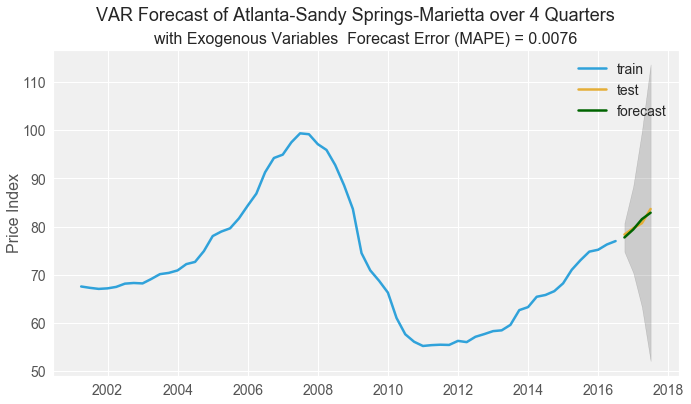

In [826]:
# Example of market '12060'
df = pd.DataFrame({'cpi':cpi['12060'],'hpi':fmhpi['12060'],'hvi':hvi['12060'],'frm':frm['mortgage30us']})
forecast, error = VAR_forecast(df, maxlags=3, h=4, market='Atlanta-Sandy Springs-Marietta', disp=True)

In [836]:
# Apply VECM forecast on each of the 10 markets
forecast_2_2 = []
error_2_2 = []
for m in cpi.columns.values:
    df = pd.DataFrame({'cpi':cpi[m],'hpi':fmhpi[m],'hvi':hvi[m],'frm':frm['mortgage30us']})
    forecast, error = VAR_forecast(data=df, maxlags=3, h=4, market=m, disp=False)
    forecast_2_2.append(forecast)
    error_2_2.append(error)
forecast_2_2 = pd.concat(forecast_2_2, axis=1)
forecast_2_2.columns = cpi.columns
forecast_2_2

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/yunkunxu/miniconda3/lib/python3.6

,12060,14460,16980,19100,26420,31080,33100,35620,37980,47900
period,,,,,,,,,,
2016-10-01,77.7439,105.1780,82.5514,98.9062,104.5984,118.2425,107.7225,130.6210,96.7822,98.7806
2017-01-01,79.4062,105.8602,82.9209,99.5920,105.0179,122.3364,110.3950,133.1472,97.7640,96.6456
2017-04-01,81.5342,106.4363,83.4336,99.9602,105.5894,126.5014,113.6334,135.3378,99.0738,94.5215
2017-07-01,82.8769,106.8637,83.8654,100.4129,106.3454,130.8757,117.0676,137.5271,100.3129,92.4911


## 2.3 LTSM

In [886]:
# Define functions
def LSTM_forecast2(data, timesteps, h, market, disp=False):
    '''data can be either one time series or multiple time series with the last column being the series to forecast
    '''
    if type(data) is pd.Series:
        data = data.to_frame()
    
    features = data.shape[1]
    reframed = series_to_supervised(data, timesteps, 1)
    selected = [i for i in range(timesteps*features)] + [reframed.shape[1]-1]
    reframed = reframed.iloc[:, selected]
    
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(reframed)
    X, y = scaled[:, :-1], scaled[:, -1]
    
    # split into train and test datasets
    X_train, y_train = X[0:-h, :], y[0:-h]
    X_test, y_test = X[-h:, :], y[-h:]
    print('Dimensions:')
    print('--X_train: ', X_train.shape)
    print('--y_train: ', y_train.shape)
    print('--X_test:  ', X_test.shape)
    print('--y_test:  ', y_test.shape)
    
    # reshape input to be 3D [samples, timesteps, features]
    X_train_reshape = X_train.reshape(X_train.shape[0], timesteps, features)
    X_test_reshape = X_test.reshape(X_test.shape[0], timesteps, features)
    print('Dimensions after reshaping:')
    print('--X_train_reshape: ', X_train_reshape.shape)
    print('--X_test_reshape:  ', X_test_reshape.shape)
    
    # design the network architecture
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshape.shape[1], X_train_reshape.shape[2])))
    #model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    #model.add(Dense(25))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    result = model.fit(X_train_reshape, y_train, epochs=100, batch_size=40, 
                       validation_data=(X_test_reshape, y_test), verbose=2, shuffle=False) #callbacks=[EarlyStopping(monitor='val_loss',mode='min')]
    # make a forecast
    y_predict = model.predict(X_test_reshape)
    # invert scaling for forecast
    y_predict_inverse = np.concatenate((X_test, y_predict), axis=1)
    y_predict_inverse = scaler.inverse_transform(y_predict_inverse)
    forecast = pd.DataFrame({'forecast':y_predict_inverse[:,-1]}, index=data[-h:].index)
    error = mean_absolute_percentage_error(reframed.iloc[-h:,-1], forecast['forecast'])
    
    # visualize forecast
    if disp:
        plt.figure(figsize=(10,6))
        plt.plot(result.history['loss'], label='train')
        plt.plot(result.history['val_loss'], label='test')
        plt.ylabel("Loss", fontsize=16)
        plt.legend()
    
        plt.figure(figsize=(10,6))
        plt.suptitle("LSTM Forecast of " + market + " over " + str(h) + " Quarters", fontsize=18)
        plt.title("with " + str(timesteps) + " Quarters Lookback  Forecast Error (MAPE) = " + str(round(error,4)), fontsize=16)
        plt.ylabel("Price Index", fontsize=16)
        plt.plot(reframed.iloc[:-h,-1], label='train')
        plt.plot(reframed.iloc[-h:,-1], label='test')
        plt.plot(forecast['forecast'], color='darkgreen', label='forecast')
        # plt.fill_between(forecast.index, forecast['lower'], forecast['upper'], color='k', alpha=.15)
        plt.legend()
    
    return forecast, error


Dimensions:
--X_train:  (61, 4)
--y_train:  (61,)
--X_test:   (4, 4)
--y_test:   (4,)
Dimensions after reshaping:
--X_train_reshape:  (61, 1, 4)
--X_test_reshape:   (4, 1, 4)
Train on 61 samples, validate on 4 samples
Epoch 1/100
 - 10s - loss: 0.3479 - val_loss: 0.9232
Epoch 2/100
 - 0s - loss: 0.3360 - val_loss: 0.9085
Epoch 3/100
 - 0s - loss: 0.3229 - val_loss: 0.8936
Epoch 4/100
 - 0s - loss: 0.3127 - val_loss: 0.8781
Epoch 5/100
 - 0s - loss: 0.3000 - val_loss: 0.8619
Epoch 6/100
 - 0s - loss: 0.2865 - val_loss: 0.8449
Epoch 7/100
 - 0s - loss: 0.2749 - val_loss: 0.8268
Epoch 8/100
 - 0s - loss: 0.2610 - val_loss: 0.8075
Epoch 9/100
 - 0s - loss: 0.2475 - val_loss: 0.7867
Epoch 10/100
 - 0s - loss: 0.2357 - val_loss: 0.7646
Epoch 11/100
 - 0s - loss: 0.2200 - val_loss: 0.7407
Epoch 12/100
 - 0s - loss: 0.2046 - val_loss: 0.7151
Epoch 13/100
 - 0s - loss: 0.1934 - val_loss: 0.6876
Epoch 14/100
 - 0s - loss: 0.1783 - val_loss: 0.6587
Epoch 15/100
 - 0s - loss: 0.1678 - val_loss: 0.

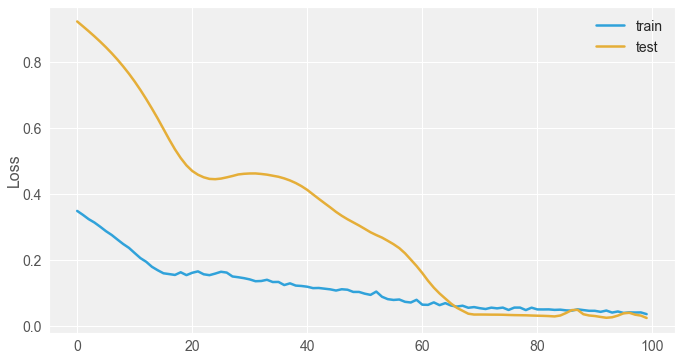

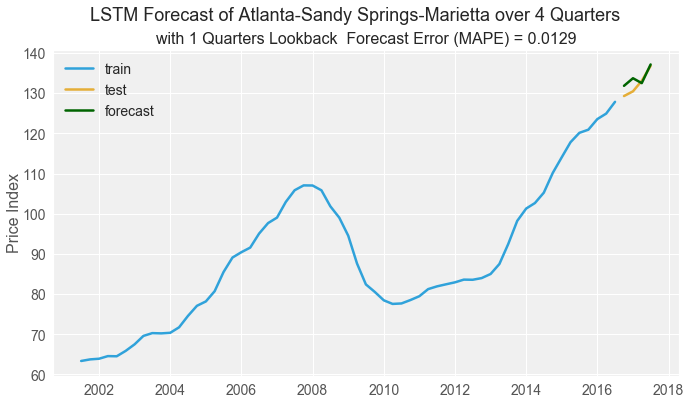

In [887]:
# Eample of market '12060' with 1 quarter lookback and other market information
df = pd.DataFrame({'hpi':fmhpi['35620'],'hvi':hvi['35620'],'frm':frm['mortgage30us'],'cpi':cpi['35620']})
forecast, error = LSTM_forecast2(df, timesteps=1, h=4, market='Atlanta-Sandy Springs-Marietta', disp=True)

In [888]:
# Apply LTSM forecast on each of the 10 markets
forecast_2_3 = []
error_2_3 = []
for m in cpi.columns.values:
    df = pd.DataFrame({'hpi':fmhpi[m],'hvi':hvi[m],'frm':frm['mortgage30us'],'cpi':cpi[m]}) # ensure the last column is the series to forecast
    forecast, error = LSTM_forecast2(df, timesteps=1, h=4, market=m, disp=False)
    forecast_2_3.append(forecast['forecast'])
    error_2_3.append(error)
forecast_2_3 = pd.concat(forecast_2_3, axis=1)
forecast_2_3.columns = cpi.columns
forecast_2_3

Dimensions:
--X_train:  (61, 4)
--y_train:  (61,)
--X_test:   (4, 4)
--y_test:   (4,)
Dimensions after reshaping:
--X_train_reshape:  (61, 1, 4)
--X_test_reshape:   (4, 1, 4)
Train on 61 samples, validate on 4 samples
Epoch 1/100
 - 10s - loss: 0.3883 - val_loss: 0.5592
Epoch 2/100
 - 0s - loss: 0.3754 - val_loss: 0.5449
Epoch 3/100
 - 0s - loss: 0.3643 - val_loss: 0.5303
Epoch 4/100
 - 0s - loss: 0.3524 - val_loss: 0.5153
Epoch 5/100
 - 0s - loss: 0.3425 - val_loss: 0.4999
Epoch 6/100
 - 0s - loss: 0.3324 - val_loss: 0.4837
Epoch 7/100
 - 0s - loss: 0.3206 - val_loss: 0.4667
Epoch 8/100
 - 0s - loss: 0.3066 - val_loss: 0.4488
Epoch 9/100
 - 0s - loss: 0.2942 - val_loss: 0.4296
Epoch 10/100
 - 0s - loss: 0.2849 - val_loss: 0.4094
Epoch 11/100
 - 0s - loss: 0.2685 - val_loss: 0.3880
Epoch 12/100
 - 0s - loss: 0.2556 - val_loss: 0.3652
Epoch 13/100
 - 0s - loss: 0.2448 - val_loss: 0.3408
Epoch 14/100
 - 0s - loss: 0.2250 - val_loss: 0.3146
Epoch 15/100
 - 0s - loss: 0.2139 - val_loss: 0.

Epoch 48/100
 - 0s - loss: 0.0941 - val_loss: 0.1881
Epoch 49/100
 - 0s - loss: 0.0906 - val_loss: 0.1720
Epoch 50/100
 - 0s - loss: 0.0832 - val_loss: 0.1583
Epoch 51/100
 - 0s - loss: 0.0863 - val_loss: 0.1474
Epoch 52/100
 - 0s - loss: 0.0790 - val_loss: 0.1401
Epoch 53/100
 - 0s - loss: 0.0803 - val_loss: 0.1327
Epoch 54/100
 - 0s - loss: 0.0814 - val_loss: 0.1236
Epoch 55/100
 - 0s - loss: 0.0758 - val_loss: 0.1114
Epoch 56/100
 - 0s - loss: 0.0745 - val_loss: 0.0982
Epoch 57/100
 - 0s - loss: 0.0652 - val_loss: 0.0863
Epoch 58/100
 - 0s - loss: 0.0640 - val_loss: 0.0751
Epoch 59/100
 - 0s - loss: 0.0680 - val_loss: 0.0590
Epoch 60/100
 - 0s - loss: 0.0676 - val_loss: 0.0461
Epoch 61/100
 - 0s - loss: 0.0633 - val_loss: 0.0452
Epoch 62/100
 - 0s - loss: 0.0527 - val_loss: 0.0462
Epoch 63/100
 - 0s - loss: 0.0611 - val_loss: 0.0470
Epoch 64/100
 - 0s - loss: 0.0656 - val_loss: 0.0495
Epoch 65/100
 - 0s - loss: 0.0534 - val_loss: 0.0480
Epoch 66/100
 - 0s - loss: 0.0543 - val_loss: 

Epoch 99/100
 - 0s - loss: 0.0505 - val_loss: 0.0848
Epoch 100/100
 - 0s - loss: 0.0502 - val_loss: 0.0841
Dimensions:
--X_train:  (61, 4)
--y_train:  (61,)
--X_test:   (4, 4)
--y_test:   (4,)
Dimensions after reshaping:
--X_train_reshape:  (61, 1, 4)
--X_test_reshape:   (4, 1, 4)
Train on 61 samples, validate on 4 samples
Epoch 1/100
 - 11s - loss: 0.3172 - val_loss: 0.9206
Epoch 2/100
 - 0s - loss: 0.3064 - val_loss: 0.9068
Epoch 3/100
 - 0s - loss: 0.2969 - val_loss: 0.8925
Epoch 4/100
 - 0s - loss: 0.2870 - val_loss: 0.8779
Epoch 5/100
 - 0s - loss: 0.2775 - val_loss: 0.8624
Epoch 6/100
 - 0s - loss: 0.2693 - val_loss: 0.8463
Epoch 7/100
 - 0s - loss: 0.2635 - val_loss: 0.8294
Epoch 8/100
 - 0s - loss: 0.2577 - val_loss: 0.8119
Epoch 9/100
 - 0s - loss: 0.2500 - val_loss: 0.7936
Epoch 10/100
 - 0s - loss: 0.2477 - val_loss: 0.7745
Epoch 11/100
 - 0s - loss: 0.2413 - val_loss: 0.7545
Epoch 12/100
 - 0s - loss: 0.2392 - val_loss: 0.7334
Epoch 13/100
 - 0s - loss: 0.2333 - val_loss: 0

Epoch 46/100
 - 0s - loss: 0.1315 - val_loss: 0.1608
Epoch 47/100
 - 0s - loss: 0.1384 - val_loss: 0.1681
Epoch 48/100
 - 0s - loss: 0.1295 - val_loss: 0.1649
Epoch 49/100
 - 0s - loss: 0.1316 - val_loss: 0.1575
Epoch 50/100
 - 0s - loss: 0.1355 - val_loss: 0.1493
Epoch 51/100
 - 0s - loss: 0.1188 - val_loss: 0.1431
Epoch 52/100
 - 0s - loss: 0.1300 - val_loss: 0.1380
Epoch 53/100
 - 0s - loss: 0.1267 - val_loss: 0.1289
Epoch 54/100
 - 0s - loss: 0.1173 - val_loss: 0.1225
Epoch 55/100
 - 0s - loss: 0.1129 - val_loss: 0.1236
Epoch 56/100
 - 0s - loss: 0.0993 - val_loss: 0.1236
Epoch 57/100
 - 0s - loss: 0.1129 - val_loss: 0.1252
Epoch 58/100
 - 0s - loss: 0.1159 - val_loss: 0.1321
Epoch 59/100
 - 0s - loss: 0.1133 - val_loss: 0.1371
Epoch 60/100
 - 0s - loss: 0.1068 - val_loss: 0.1397
Epoch 61/100
 - 0s - loss: 0.1102 - val_loss: 0.1490
Epoch 62/100
 - 0s - loss: 0.1024 - val_loss: 0.1613
Epoch 63/100
 - 0s - loss: 0.0992 - val_loss: 0.1707
Epoch 64/100
 - 0s - loss: 0.1093 - val_loss: 

Epoch 97/100
 - 0s - loss: 0.0381 - val_loss: 0.0178
Epoch 98/100
 - 0s - loss: 0.0348 - val_loss: 0.0099
Epoch 99/100
 - 0s - loss: 0.0272 - val_loss: 0.0098
Epoch 100/100
 - 0s - loss: 0.0296 - val_loss: 0.0208
Dimensions:
--X_train:  (61, 4)
--y_train:  (61,)
--X_test:   (4, 4)
--y_test:   (4,)
Dimensions after reshaping:
--X_train_reshape:  (61, 1, 4)
--X_test_reshape:   (4, 1, 4)
Train on 61 samples, validate on 4 samples
Epoch 1/100
 - 11s - loss: 0.4320 - val_loss: 0.9738
Epoch 2/100
 - 0s - loss: 0.4211 - val_loss: 0.9604
Epoch 3/100
 - 0s - loss: 0.4106 - val_loss: 0.9465
Epoch 4/100
 - 0s - loss: 0.3994 - val_loss: 0.9322
Epoch 5/100
 - 0s - loss: 0.3868 - val_loss: 0.9170
Epoch 6/100
 - 0s - loss: 0.3768 - val_loss: 0.9009
Epoch 7/100
 - 0s - loss: 0.3634 - val_loss: 0.8837
Epoch 8/100
 - 0s - loss: 0.3490 - val_loss: 0.8653
Epoch 9/100
 - 0s - loss: 0.3359 - val_loss: 0.8453
Epoch 10/100
 - 0s - loss: 0.3230 - val_loss: 0.8236
Epoch 11/100
 - 0s - loss: 0.3043 - val_loss: 0

Epoch 44/100
 - 0s - loss: 0.1239 - val_loss: 0.4287
Epoch 45/100
 - 0s - loss: 0.1272 - val_loss: 0.4210
Epoch 46/100
 - 0s - loss: 0.1251 - val_loss: 0.4137
Epoch 47/100
 - 0s - loss: 0.1209 - val_loss: 0.4063
Epoch 48/100
 - 0s - loss: 0.1225 - val_loss: 0.3970
Epoch 49/100
 - 0s - loss: 0.1226 - val_loss: 0.3872
Epoch 50/100
 - 0s - loss: 0.1182 - val_loss: 0.3768
Epoch 51/100
 - 0s - loss: 0.1200 - val_loss: 0.3656
Epoch 52/100
 - 0s - loss: 0.1019 - val_loss: 0.3530
Epoch 53/100
 - 0s - loss: 0.1145 - val_loss: 0.3418
Epoch 54/100
 - 0s - loss: 0.1045 - val_loss: 0.3319
Epoch 55/100
 - 0s - loss: 0.1071 - val_loss: 0.3234
Epoch 56/100
 - 0s - loss: 0.1024 - val_loss: 0.3144
Epoch 57/100
 - 0s - loss: 0.1048 - val_loss: 0.3064
Epoch 58/100
 - 0s - loss: 0.1002 - val_loss: 0.2980
Epoch 59/100
 - 0s - loss: 0.1040 - val_loss: 0.2898
Epoch 60/100
 - 0s - loss: 0.1003 - val_loss: 0.2826
Epoch 61/100
 - 0s - loss: 0.0897 - val_loss: 0.2746
Epoch 62/100
 - 0s - loss: 0.0876 - val_loss: 

Epoch 95/100
 - 0s - loss: 0.0620 - val_loss: 0.0879
Epoch 96/100
 - 0s - loss: 0.0522 - val_loss: 0.0891
Epoch 97/100
 - 0s - loss: 0.0583 - val_loss: 0.0803
Epoch 98/100
 - 0s - loss: 0.0592 - val_loss: 0.0733
Epoch 99/100
 - 0s - loss: 0.0602 - val_loss: 0.0670
Epoch 100/100
 - 0s - loss: 0.0560 - val_loss: 0.0495
Dimensions:
--X_train:  (61, 4)
--y_train:  (61,)
--X_test:   (4, 4)
--y_test:   (4,)
Dimensions after reshaping:
--X_train_reshape:  (61, 1, 4)
--X_test_reshape:   (4, 1, 4)
Train on 61 samples, validate on 4 samples
Epoch 1/100
 - 12s - loss: 0.5398 - val_loss: 0.8638
Epoch 2/100
 - 0s - loss: 0.5269 - val_loss: 0.8485
Epoch 3/100
 - 0s - loss: 0.5129 - val_loss: 0.8330
Epoch 4/100
 - 0s - loss: 0.5014 - val_loss: 0.8173
Epoch 5/100
 - 0s - loss: 0.4899 - val_loss: 0.8011
Epoch 6/100
 - 0s - loss: 0.4764 - val_loss: 0.7843
Epoch 7/100
 - 0s - loss: 0.4645 - val_loss: 0.7666
Epoch 8/100
 - 0s - loss: 0.4473 - val_loss: 0.7479
Epoch 9/100
 - 0s - loss: 0.4344 - val_loss: 0

,12060,14460,16980,19100,26420,31080,33100,35620,37980,47900
period,,,,,,,,,,
2016-10-01,81.1068,109.9591,82.4295,103.1032,106.4978,117.9988,106.2515,134.1329,95.1688,103.7149
2017-01-01,82.8494,113.3565,83.4270,105.6936,105.9866,121.4834,108.0760,136.3439,96.2099,103.8731
2017-04-01,85.3919,121.0131,83.0671,110.9536,107.1054,122.4342,106.9287,134.0317,97.6942,101.9840
2017-07-01,87.9763,130.3979,86.5161,113.5424,107.6737,126.1648,108.8842,139.1846,98.7509,103.4173


# Summary

In [898]:
# Summarize the forecasting errors measured by MAPE for all models
error_summary = {'ARIMA': error_1_1, 'VECM1': error_1_2, 'VAR1': error_1_3, 'LSTM11': error_1_4_1,
                'LSTM12': error_1_4_2, 'VECM2': error_2_1, 'VAR2': error_2_2, 'LSTM2': error_2_3}
error_summary = pd.DataFrame(error_summary, index=cpi.columns.values)
error_summary

,ARIMA,VECM1,VAR1,LSTM11,LSTM12,VECM2,VAR2,LSTM2
12060,0.0180,0.0354,0.0480,0.0147,0.0212,0.0082,0.0076,0.0463
14460,0.1076,0.0758,0.0542,0.0791,0.0940,0.0882,0.0932,0.0226
16980,0.0390,0.0115,0.0658,0.0243,0.0209,0.0392,0.0414,0.0340
19100,0.0439,0.0011,0.0257,0.0168,0.0532,0.0096,0.0353,0.0473
26420,0.0045,0.0163,0.0096,0.0458,0.0285,0.0578,0.0078,0.0215
31080,0.0182,0.0118,0.0180,0.0424,0.0534,0.0034,0.0310,0.0108
33100,0.0716,0.0635,0.0270,0.0286,0.0176,0.0435,0.0596,0.0157
35620,0.0225,0.0277,0.0170,0.0240,0.0740,0.0209,0.0133,0.0267
37980,0.0048,0.0270,0.0092,0.0127,0.0222,0.0174,0.0044,0.0164
47900,0.0491,0.0071,0.0730,0.0519,0.0375,0.0094,0.0477,0.0284


In [899]:
# Summary statistics
error_summary.describe()

,ARIMA,VECM1,VAR1,LSTM11,LSTM12,VECM2,VAR2,LSTM2
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000
mean,0.0379,0.0277,0.0348,0.0340,0.0422,0.0298,0.0341,0.0270
std,0.0323,0.0246,0.0236,0.0209,0.0259,0.0273,0.0281,0.0124
min,0.0045,0.0011,0.0092,0.0127,0.0176,0.0034,0.0044,0.0108
25%,0.0181,0.0115,0.0173,0.0186,0.0214,0.0095,0.0092,0.0177
50%,0.0308,0.0216,0.0264,0.0264,0.0330,0.0192,0.0331,0.0247
75%,0.0478,0.0335,0.0526,0.0450,0.0534,0.0424,0.0461,0.0326
max,0.1076,0.0758,0.0730,0.0791,0.0940,0.0882,0.0932,0.0473


The LSTM model with exogenous variables: House Price Index, House Value Index and mortgage rates yields the best forecasting results in terms of both accruacy (smallest average forecasting error) and robustness (smallest standard deviation).

# Final Forecasting

Due to the time constraint, I choose VECM as an example of final forecasting considering it is relatively easy to train.

In [982]:
# Define functions
def VECM_forecast2(data, h, market, disp=False):
    # build a VECM model
    model = VECM(data, k_ar_diff = 3, coint_rank = 4)
    result = model.fit()
    
    # make a Forecast
    forecast, lower, upper = result.predict(h, 0.05)
    forecast = pd.DataFrame(forecast, columns=data.columns)
    lower = pd.DataFrame(lower, columns=data.columns)
    upper = pd.DataFrame(upper, columns=data.columns)
    
    # visualize forecast result
    if disp:
        print(result.summary())
    
    return forecast

In [987]:
# Apply VECM forecast on each of the 10 markets
final_forecast = []

for m in cpi.columns.values:
    df = pd.DataFrame({'cpi':cpi[m],'hpi':fmhpi[m],'hvi':hvi[m],'frm':frm['mortgage30us']})
    forecast = VECM_forecast2(data=df, h=8, market=m, disp=False)
    final_forecast.append(forecast['cpi'])

final_forecast = pd.concat(final_forecast, axis=1)
final_forecast.columns = cpi.columns
final_forecast

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/yunkunxu/miniconda3/lib/python3.6

,12060,14460,16980,19100,26420,31080,33100,35620,37980,47900
0,86.7556,125.8070,92.6395,106.9480,107.3492,126.7176,108.4642,140.2651,100.3937,101.4592
1,89.3277,128.5192,93.2640,109.1130,109.7319,129.1370,109.6365,142.9846,100.9623,103.8576
2,91.3032,130.5584,93.7165,111.4633,111.9724,131.7672,110.8945,146.0471,101.2431,106.1854
3,93.5847,131.8297,93.6396,114.0256,114.9723,134.7986,112.4961,149.7139,101.0558,108.5087
4,96.1395,133.1974,92.8171,117.0767,118.9192,138.3026,113.9674,153.3305,100.7194,110.9894
5,97.6534,134.6076,91.4859,120.1935,122.7560,142.3517,115.3281,156.4615,100.4143,113.0405
6,98.4076,135.4958,90.1881,123.0018,126.0771,146.9608,116.4784,159.4340,99.6802,114.0955
7,99.7473,136.0186,88.9593,125.8650,129.7216,152.0071,117.4089,162.6623,98.4093,114.4249


In [989]:
# Output
final_forecast.columns = market_names['name'].values.tolist()
final_forecast.to_csv('cpi_forecasted.csv')